
# I'm Something of a Painter Myself

Kaggle Competition Notebook: https://www.kaggle.com/competitions/gan-getting-started/overview


## Step One: Project Overview


In this project, we want to build a GAN so that we can tell the difference between a real photo and a painting by Monet. In the process we'll also work to generate images that are stylized to look like Monet paintings. Before we get started, let's talk a little more about GANs. 


A Generative Adversarial Network (GAN) is a type of deep learning model that is typically used to generate data that mimics data from the input set. 
Typically a GAN is made up of two neural networks including a generator and a discriminator. 
Generally speaking, there is an input dataset of "real" data and a set of "fake" data, generated by the generator, that is fed to the discriminator, whose job is to classify the data as being real or fake. 

Training is basically the two networks playing a game against each other (hence the 'adversarial' part of GAN). The discriminator's goal is to learn how to reliably pick the real image, while the generator's goal is to fool the generator so it picks the fake image. At the beginning of training generators are really producing random noise and the discriminator is making random guesses. But as training continues, the results of who wins/loses is fed back to each model to help it learn how to either pick images better or generate images better. The process continues until the generator is able to reliably fool the discriminator. 

### Helpful resources: 
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
- https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/
- https://www.youtube.com/watch?v=_qB4B6ttXk8
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook


## Step Two: Exploratory Data Analysis & Data Preparation

### Loading Kaggle Data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


In [2]:
dataset_path = KaggleDatasets().get_gcs_path()
print(f"Path is: {dataset_path}")

Path is: gs://kds-c6f4ac40f352fba0e46e4261125023f77b606928b42ea7719e0742da


The above dataset has 4 different directories with data:
- `monet_jpg` and `photo_jpg` contain `.jpg` images that we can use to build and train the model that we'll use to generate images from
- The `photo_tfrec` and `monet_tfrec` directories contain [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tfrecord/)

Next we can load the data to see how it is structured - for this section I used Amy Jang's [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) to help understand how to load the data. 

In [3]:
import matplotlib.pyplot as plt
import os

monet_dir = f'{dataset_path}/monet_jpg'
photo_dir = f'{dataset_path}/photo_jpg'
monet_rec_dir = f'{dataset_path}/monet_tfrec'
photo_rect_dir = f'{dataset_path}/photo_tfrec'

IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3

# Records contain the image_name, image and target
def parse_record_and_image(record):
    features = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_record = tf.io.parse_single_example(record, features)
    # Process image
    image = tf.image.decode_jpeg(parsed_record['image'], channels=3) 
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def load_images(tfrec_dir: str):
    tfrecord_files = tf.io.gfile.glob(os.path.join(tfrec_dir, "*.tfrec"))
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    return dataset.map(parse_record_and_image, num_parallel_calls=AUTOTUNE)    


In [4]:
monet_data = load_images(monet_rec_dir).batch(1)
photo_data = load_images(photo_rect_dir).batch(1)

## Data Visualization & Analysis

Now that the data is loaded we can take a look at what the photo vs monet images look like to get an idea for what we'll need to build with the generator. In this section I display the input image as well as the image broken down into its RGB channels so that we can take a look at how each image is distributed.

In [5]:
# Image Helpers: 
import seaborn as sns
from matplotlib.gridspec import GridSpec

def show_image_basic(image, title=None):
    plt.axis('off')
    if title:
        plt.gca().set_title(title)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().imshow(image*0.5+0.5)

def show_multiple_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, image in enumerate(dataset.take(num_images)):
        axes[i].imshow(image[0] * 0.5 + 0.5)  # Rescale the image back to [0, 1]
        axes[i].axis('off')
    plt.show()

def show_image_by_channel(image, show_dist:bool = False):
    channels = {
        'red': image[:,:,0],
        'green':image[:,:,1],
        'blue':image[:,:,2],
    }
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 0.5, 0.5])
    ax_kde = fig.add_subplot(gs[1, :])
    # Plot images in the top row
    for i, channel in enumerate(channels):
        ax_img = fig.add_subplot(gs[0, i])
        ax_img.imshow(channels[channel], cmap=channel.capitalize()+"s")
        ax_img.set_title(f'{channel.capitalize()} Channel')
        ax_img.axis('off')

        channel_data = channels[channel].numpy().ravel()
        sns.kdeplot(channel_data, color=channel, ax=ax_kde)
        
        if show_dist:
            ax_hist = fig.add_subplot(gs[2, i])
            ax_hist.hist(channel_data, bins=64, range=(-1, 1), color=channel, alpha=0.5)
            ax_hist.grid(True, alpha=0.5)
            ax_hist.set_yticklabels([])
            
            ax_kde.set_title('Pixel Density by Channel')
            ax_kde.set_xlabel('Pixel Value')
            ax_kde.set_ylabel('Density')
            ax_kde.legend([f'{channel.capitalize()} Channel' for channel in channels])
            ax_kde.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


### Photo Images

In [6]:
# show_multiple_images(photo_data, num_images = 3)

In [7]:
# for i, image in enumerate(photo_data.take(3)):
#     show_image_by_channel(image[0], show_dist = True)

### Monet Images

In [8]:
# show_multiple_images(monet_data, num_images = 3)

In [9]:
# for i, image in enumerate(monet_data.take(3)):
#     show_image_by_channel(image[0], show_dist = True)

## Step Three: Model Architecture

TODO: Add description of approach

After reading throguh the tutorial, a common approach to building a cycleGAN for doing transforms, is to build a U-Net Generator and a PatchGAN discriminator. In this section I will set each of those  up. 

Build generator, then build discriminator then train.

In our case a cycle GAN is probably the best appraoch. The idea behind a cycle gan is to try and take characteristics from one image and embed them into another, which is exactly what we want to do. We can also make use of the PatchGAN discriminator. 
The architecture I'm planning to use is further outlined [here](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/) 


## Generator Definition



Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.


We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [10]:
def block(filters, size,  stride:int = 2, increase:bool = False, apply_instancenorm=True, apply_dropout=False):
    result = keras.Sequential()
    if increase: 
        result.add(layers.Conv2DTranspose(filters, size, strides=stride,
                                  padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                  use_bias=False))

        result.add(tfa.layers.InstanceNormalization())

        if apply_dropout:
            result.add(layers.Dropout(0.5))
    else:
        result.add(layers.Conv2D(filters, size, strides=stride, padding='same',
                                 kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False))

        if apply_instancenorm:
            result.add(tfa.layers.InstanceNormalization())

    result.add(layers.LeakyReLU())

    return result

In [11]:
def Generator(depth: int =5, do_skip: bool = True, activation:str = 'tanh'):
    encoder_layers = [
        block(64, 7, apply_instancenorm=False),
        block(128, 3), 
        block(256, 3), 
    ]
    
    decoder_layers = [
        block(256, 3, increase=True),
        block(128, 3, increase=True),
        block(64, 7, increase=True),
    ]
    
    # Build Transform Layers of UNET 
    transform_decrease = [block(256, 3) for i in range(depth)]
    transform_increase = [block(256, 3, increase=True, apply_dropout=True) for i in range(depth - 2)] + [block(256, 3, increase=True)]
    
    
    decreasing_layers = encoder_layers + transform_decrease
    increasing_layers = transform_increase + decoder_layers
    skip_connections = []
    
    #Construct U-Net Architecture
    inputs = layers.Input(shape=[256,256,3])
    generator_layers = inputs
    
    for layer in decreasing_layers:
        # Append current layer to architecture
        generator_layers = layer(generator_layers)
        if do_skip:
            skip_connections.insert(0, generator_layers)
    
    if do_skip: 
        skip_connections = skip_connections[1:] # Remove inputs from list
        for layer, skip_con in zip(increasing_layers, skip_connections):
            generator_layers = layer(generator_layers)
            generator_layers = layers.Concatenate()([generator_layers, skip_con])
    else:
        for layer in increasing_layers:
            generator_layers = layer(generator_layers)
    
    output_layer = layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              activation=activation)

    generator_layers = output_layer(generator_layers)
    return keras.Model(inputs=inputs, outputs=generator_layers)
Generator().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  73984       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  295424      sequential_1[0][0]               
______________________________________________________________________________________________

### Untrained Generator Example:

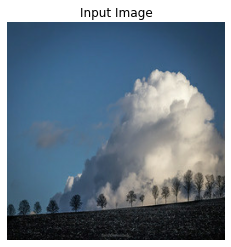

In [12]:
example_photo = next(iter(photo_data))
show_image_basic(example_photo[0], title= "Input Image")

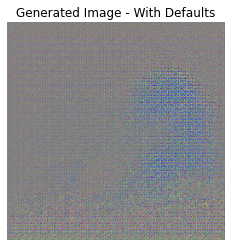

In [13]:
monet_generator = Generator()
to_monet = monet_generator(example_photo)

show_image_basic(to_monet[0], title= "Generated Image - With Defaults")

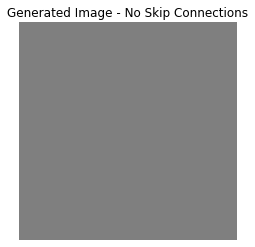

In [14]:
monet_generator = Generator(do_skip = False)
to_monet = monet_generator(example_photo)

show_image_basic(to_monet[0], title= "Generated Image - No Skip Connections")

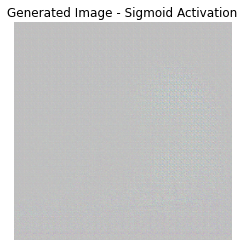

In [15]:
monet_generator = Generator(activation = 'sigmoid')
to_monet = monet_generator(example_photo)

show_image_basic(to_monet[0], title= "Generated Image - Sigmoid Activation")

## Discriminator Definition

TODO EDIT DESCRIPTION

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [16]:
def Discriminator():
    # PatchGAN Architecture
    initializer = tf.random_normal_initializer(0., 0.02)

    input_layer = layers.Input(shape=[256, 256, 3], name='input_image')

    discriminator_layers = input_layer
    layer_list = [
        block(64, 4, apply_instancenorm=False),
        block(128, 4),
        block(256, 4),
        layers.ZeroPadding2D(),
        layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False), 
        tfa.layers.InstanceNormalization(), 
        layers.LeakyReLU(), 
        layers.ZeroPadding2D(), 
        layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)
    ]

    for layer in layer_list:
        discriminator_layers = layer(discriminator_layers)

    return tf.keras.Model(inputs=input_layer, outputs=discriminator_layers)

Discriminator().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_60 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_61 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_62 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_58 (I (None, 31, 31, 512)       1024

### Define the CycleGAN

For the actual cycleGAN we'll proceed with the implementation in [Amy Jang's tutorial ](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook): 

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In order to use the Tutorial CycleGAN we'll also need to import the loss functions - additional information on the loss functions can be found [here](https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/). 

In [38]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [35]:
def build_and_train_cyclegan(epochs = 2):
    # Create generators and discriminators 
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator()
        
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(),
        p_gen_optimizer = tf.keras.optimizers.Adam(),
        m_disc_optimizer = tf.keras.optimizers.Adam(),
        p_disc_optimizer = tf.keras.optimizers.Adam(),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    
    cycle_gan_model.fit(
        tf.data.Dataset.zip((monet_data, photo_data)),
        epochs=epochs
    )
    
    return monet_generator
    

def view_generated(generator, num_images:int = 5):
    _, ax = plt.subplots(2, 5, figsize=(20, 5))
    for i, img in enumerate(photo_data.take(num_images)):
        prediction = generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[0, i].imshow(img)
        ax[1, i].imshow(prediction)
        ax[0, i].set_title("Input Image")
        ax[1, i].set_title("Generated Image")
        ax[0, i].axis("off")
        ax[1, i].axis("off")
    plt.show()

In [26]:
default_generator = build_and_train_cyclegan()

Epoch 1/2
300/300 [==============================] - 104s 199ms/step - monet_gen_loss: 4.2854 - photo_gen_loss: 4.3546 - monet_disc_loss: 0.7315 - photo_disc_loss: 0.7335n_loss: 4.6637 - photo_gen_loss: 4.7398 - monet_disc_loss:  - 88s 198ms/step - monet_gen_loss: 4.5846 - photo_gen_loss: 4.6687 - mon - 93s 198ms/step - monet_gen_loss: 4.5005 - photo_gen_loss: 4.5806 - monet_disc_loss: 0.7362 - photo_disc_loss: 0.73 - 93s 198ms/step - monet_gen_l
Epoch 2/2
300/300 [==============================] - 61s 202ms/step - monet_gen_loss: 3.3667 - photo_gen_loss: 3.3988 - monet_disc_loss: 0.6868 - photo_disc_loss: 0.6910


# Visualize our Monet-esque photos

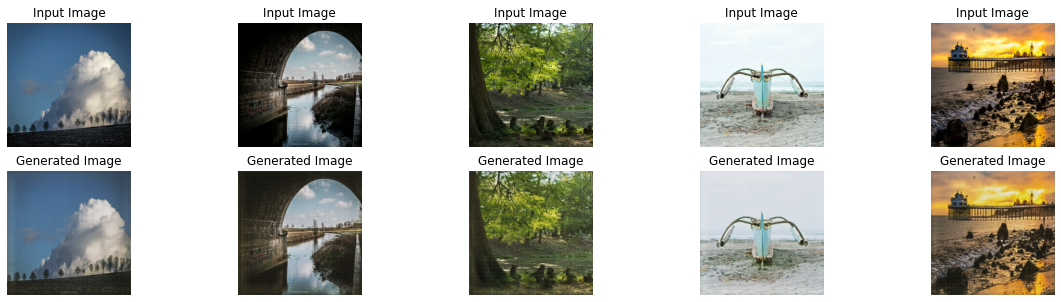

In [36]:
view_generated(default_generator, 5)

# Create submission file

In [ ]:
# import PIL
# ! mkdir ../images

In [ ]:
# i = 1
# for img in photo_ds:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [ ]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")